In [1]:
!uv pip install scikit-image

Using Python 3.12.8 environment at: /home/taylor/code/ExtremeWeatherBench/.venv
Audited 1 package in 60ms


In [2]:
import xarray as xr
import numpy as np
import regionmask
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import dataclasses
from skimage.feature import peak_local_max
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage import measure
from typing import Literal, Sequence, Optional
from scipy import spatial
from itertools import product
from collections import namedtuple

# Permutation Notes

As I'm writing out the MWE's, here's some notes on what I think might need to be accounted for:

1. Models that run every 3, 6, 12, 24 hours and how that translates to the max/min metrics (all valid times in a 12 hour frequency/6 hour resolution have 21 lead times, for example, compared to 6/6 runs with 41)
2. When to aggregate over lat/lons for area-averaged metrics
3. (TC) To find the local minima, the arrays need to be 2d; cannot roll up to (location, time) until after contours are found

In [3]:
def convert_longitude_to_360(longitude: float) -> float:
    """Convert a longitude from the range [-180, 180) to [0, 360)."""
    return np.mod(longitude, 360)

def lead_time_init_time_to_valid_time(forecast):
    """Convert init_time and lead_time to valid_time.
    
    Args:
        forecast: The forecast dataset.

    Returns:
        The forecast dataset with valid_time dimension.
    """
    if 'lead_time' not in forecast.dims or 'init_time' not in forecast.dims:
        raise ValueError("lead_time and init_time must be dimensions of the forecast dataset")
    
    lead_time_grid, init_time_grid = np.meshgrid(forecast.lead_time, forecast.init_time)
    valid_times = (
    init_time_grid.flatten()
    + pd.to_timedelta(lead_time_grid.flatten(), unit="h").to_numpy()
    )
    return valid_times

# Subset timesteps for forecast
def derive_indices_from_init_time_and_lead_time(
    dataset: xr.Dataset,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
) -> np.ndarray:
    """Derive the indices of valid times in a dataset when the dataset has init_time and lead_time coordinates.

    Args:
        dataset: The dataset to derive the indices from.
        start_date: The start date to derive the indices from.
        end_date: The end date to derive the indices from.

    Returns:
        The indices of valid times in the dataset.

    Example:
        >>> import xarray as xr
        >>> import datetime
        >>> import pandas as pd
        >>> from extremeweatherbench.utils import (
        ...     derive_indices_from_init_time_and_lead_time,
        ... )
        >>> ds = xr.Dataset(
        ...     coords={
        ...         "init_time": pd.date_range("2020-01-01", "2020-01-03"),
        ...         "lead_time": [0, 24, 48],  # hours
        ...     }
        ... )
        >>> start = datetime.datetime(2020, 1, 1)
        >>> end = datetime.datetime(2020, 1, 4)
        >>> indices = derive_indices_from_init_time_and_lead_time(ds, start, end)
        >>> print(indices)
        array([0, 0, 1, 1, 2])
    """
    valid_times = lead_time_init_time_to_valid_time(dataset)
    valid_times_reshaped = valid_times.reshape(
        (
            dataset.init_time.shape[0],
            dataset.lead_time.shape[0],
        )
    )
    valid_time_mask = (valid_times_reshaped > pd.to_datetime(start_date)) & (
        valid_times_reshaped < pd.to_datetime(end_date)
    )
    valid_time_indices = np.asarray(valid_time_mask).nonzero()

    # The first index will subset init_time based on the first valid_time_reshaped line above
    # we don't need to subset lead_time but it might be useful in the future
    init_time_subset_indices = valid_time_indices[0]

    return init_time_subset_indices

def remove_ocean_gridpoints(dataset: xr.Dataset,drop: bool = True) -> xr.Dataset:
    """Subset a dataset to only include land gridpoints based on a land-sea mask.

    Args:
        dataset: The input xarray dataset.

    Returns:
        The dataset masked to only land gridpoints.
    """
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    land_sea_mask = land.mask(dataset.longitude, dataset.latitude)
    land_mask = land_sea_mask == 0
    # Subset the dataset to only include land gridpoints
    return dataset.where(land_mask, drop=drop)

In [4]:
#: ERA5 as a standin for forecast
ERA5_URI = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
era5 = xr.open_zarr(
    ERA5_URI,
    chunks=None,
    storage_options=dict(token="anon"),
)

In [216]:
@dataclasses.dataclass
class CoordinateBounds:
    min_lat: float
    max_lat: float
    min_lon: float
    max_lon: float


class CycloneDatasetBuilder:
    """
    A class to find cyclones in a dataset using the TempestExtremes criteria.
    <insert citation here>
    """

    def orography(self, ds: xr.Dataset) -> xr.DataArray:
        if 'geopotential_at_surface' in ds.variables:
            return ds['geopotential_at_surface']/9.80665
        else:
            era5 = xr.open_zarr(
                        ERA5_URI,
                        chunks=None,
                        storage_options=dict(token="anon"),
                    )
            return era5.isel(time=1000000)['geopotential_at_surface'].sel(latitude=ds.latitude, longitude=ds.longitude)/9.80665
        
    def calculate_wind_speed(self, u_wind: xr.DataArray, v_wind: xr.DataArray) -> xr.DataArray:
        """Calculate the wind speed from the u and v components.
        """
        return np.hypot(u_wind, v_wind)
    
    def subset_variable(self, var_name: str, level_name: str = 'level', level_value: Optional[int | Sequence[int]] = None):
        if level_value is None:
            return self.ds[var_name]
        else:
            return self.ds[var_name].sel({level_name: level_value})
    
    def generate_geopotential_thickness(self, var_name: str = 'geopotential', level_name: str = 'level', top_level_value: int | Sequence[int] = [200,300,400], bottom_level_value: int = 500):
        geopotential_heights = self.subset_variable(var_name, level_name, top_level_value)
        geopotential_height_bottom = self.subset_variable(var_name, level_name, bottom_level_value)
        geopotential_thickness = (geopotential_heights - geopotential_height_bottom) / 9.80665
        geopotential_thickness.attrs = dict(description="Geopotential thickness of level and 500 hPa", units="m")
        return geopotential_thickness
    
    def subset_time(self, start_date: pd.Timestamp, end_date: pd.Timestamp):
        return self.ds.sel(time=slice(start_date, end_date))
    
    def subset_bounds(self, bounds: CoordinateBounds):
        return self.ds.sel(latitude=slice(bounds.max_lat, bounds.min_lat), longitude=slice(bounds.min_lon, bounds.max_lon))
    
    def subset_variables(self, tc_variable_amount: Literal['min','max']):
        """Subset the variables based on the variables argument.
        
        Using "min" will subset the minimum required variables - sea level pressure and geopotential thickness.
        Using "max" will subset the maximum required variables - sea level pressure, geopotential thickness, u and v surface winds, u and v 850 hPa winds, and air temperature at 400 hPa.
        Args:
            vars: The variable pattern to subset.

        Returns:
            The subsetted variables.
        """
        if tc_variable_amount == 'min':
            output = xr.Dataset({'mean_sea_level_pressure': self.subset_variable('mean_sea_level_pressure'),
                             'geopotential_thickness': self.generate_geopotential_thickness(top_level_value=300, bottom_level_value=500),
                             'surface_wind_speed': self.calculate_wind_speed(self.subset_variable('10m_u_component_of_wind'), self.subset_variable('10m_v_component_of_wind')),
                             'orography': self.orography(self.ds)},
                            )
        elif tc_variable_amount == 'max':
            output = xr.Dataset({'mean_sea_level_pressure': self.subset_variable('mean_sea_level_pressure'),
                             'geopotential_thickness': self.generate_geopotential_thickness(top_level_value=300, bottom_level_value=500),
                             'surface_wind_speed': self.calculate_wind_speed(self.subset_variable('10m_u_component_of_wind'), self.subset_variable('10m_v_component_of_wind')),
                             'u_component_of_wind': self.subset_variable('u_component_of_wind', level_value=850),
                             'v_component_of_wind': self.subset_variable('v_component_of_wind', level_value=850),
                             'temperature': self.subset_variable('temperature', level_value=[300,400,500]),
                             'orography': self.orography(self.ds)},
                            )
        return output

    def build_dataset(self, ds: xr.Dataset, start_date: pd.Timestamp, end_date: pd.Timestamp, bounds: CoordinateBounds, hour_subset: list[int] = [0,6,12,18], tc_variable_amount: Literal['min','max'] = 'min'):
        """
        Build a dataset of the cyclone data.
        """
        self.ds = ds.sel(time=ds.time.dt.hour.isin(hour_subset))
        self.ds = self.subset_time(start_date, end_date)
        self.ds = self.subset_bounds(bounds)
        # subset variables in line with TempestExtremes requirements
        te_dataset = self.subset_variables(tc_variable_amount)
        return te_dataset

Location = namedtuple('Location', ['latitude', 'longitude'])

@dataclasses.dataclass
class TC:
    id: int
    valid_time: pd.Timestamp
    coordinate: Location
    vmax: float
    slp: float


@dataclasses.dataclass
class TCTrack:
    id: int
    track: list[TC]

    def plot(self, ax: plt.Axes, *args,**kwargs):
        """
        Plot the TCTrack line on the given axes.
        """
        # Extract lat/lon coordinates from track
        lats = [tc.coordinate.latitude for tc in self.track]
        lons = [tc.coordinate.longitude for tc in self.track]
        
        # Plot the track line
        line = ax.plot(lons, lats, *args, **kwargs)
        return line
    
    @property
    def valid_times(self) -> list[pd.Timestamp]:
        return [tc.valid_time for tc in self.track]
    
    @property
    def lats(self):
        return [tc.coordinate.latitude for tc in self.track]
    
    @property
    def lons(self):
        return [tc.coordinate.longitude for tc in self.track]

    @property
    def vmax(self) -> list[float]:
        return [tc.vmax for tc in self.track]
    
    @property
    def slp(self) -> list[float]:
        return [tc.slp for tc in self.track]


def find_furthest_contour_from_point(contour: np.ndarray, point: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Find the two points in a contour that are furthest apart.
    From https://stackoverflow.com/questions/50468643/finding-two-most-far-away-points-in-plot-with-many-points-in-python
    """

    # Calculate distances from point to all points in contour
    distances = spatial.distance.cdist([point], contour)[0]
    # Find index of point with maximum distance
    furthest_idx = np.argmax(distances)
    
    # Get the furthest point
    i = furthest_idx
    return contour[i]

def convert_from_cartesian_to_latlon(input_point: np.ndarray, ds_mapping: xr.Dataset) -> tuple[float, float]:
    """Convert a point from the cartesian coordinate system to the lat/lon coordinate system.

    Args:
        input_point: The point to convert, represented as a tuple (y, x) in the cartesian coordinate system.
        ds_mapping: The dataset containing the latitude and longitude coordinates.

    Returns:
        The point in the lat/lon coordinate system, represented as a tuple (latitude, longitude) in degrees.
    """
    return (
        ds_mapping.isel(
            latitude=int(input_point[0]), 
            longitude=int(input_point[1])
            ).latitude.values, 
       
        ds_mapping.isel(
            latitude=int(input_point[0]), 
            longitude=int(input_point[1])
            ).longitude.values
    )

def calculate_haversine_degree_distance(input_a: Sequence[float], input_b: Sequence[float]) -> float:
    """Calculate the great-circle distance between two points on the Earth's surface.
    
    Args:
        input_a: The first point, represented as an ndarray of shape (2,n) in degrees lat/lon.
        input_b: The second point(s), represented as an ndarray of shape (2,n) in degrees lat/lon.

    Returns:
        The great-circle distance between the two points in kilometers.
    """
    # Convert to radians for calculations
    lat1 = np.radians(input_a[0])
    lon1 = np.radians(input_a[1])
    lat2 = np.radians(input_b[0])
    lon2 = np.radians(input_b[1])
    
    # Haversine formula for great circle distance
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = np.degrees(c)  # Convert back to degrees
    return distance



def create_great_circle_mask(ds: xr.Dataset, latlon_point: tuple[float, float], radius_degrees: float) -> xr.DataArray:
    """
    Create a circular mask based on great circle distance for an xarray dataset.
    
    Parameters:
    -----------
    ds : xarray.Dataset or xarray.DataArray
        Dataset with 'latitude' and 'longitude' coordinates
    center_lat : float
        Latitude of the center point
    center_lon : float
        Longitude of the center point
    radius_degrees : float
        Radius in degrees of great circle distance
    
    Returns:
    --------
    mask : xarray.DataArray
        Boolean mask where True indicates points within the radius
    """
    
    distance = calculate_haversine_degree_distance(latlon_point, (ds.latitude, ds.longitude))
    # Create mask as xarray DataArray
    mask = distance <= radius_degrees
    
    return mask

def find_contours_from_point_specified_field(field: xr.DataArray, point: tuple[float, float], level: float) -> Sequence[tuple[float, float]]:
    field_at_point = field - field.isel(latitude=point[0], longitude=point[1])
    contours = measure.find_contours(field_at_point.values, level=level, positive_orientation='high')
    return contours

def find_valid_contour_from_point(contour: Sequence[tuple[float, float]], point: tuple[float, float], ds_mapping: xr.Dataset) -> tuple[float, float]:
    gc_distance_point = find_furthest_contour_from_point(contour, point)
    gc_distance_point_latlon = convert_from_cartesian_to_latlon(gc_distance_point, ds_mapping)
    point_latlon = convert_from_cartesian_to_latlon(point, ds_mapping)
    gc_distance_contour_distance = calculate_haversine_degree_distance(gc_distance_point_latlon, point_latlon)
    return gc_distance_contour_distance
    
    
#event metadata
start_date = pd.Timestamp('2024-09-20 00:00')
end_date = pd.Timestamp('2024-09-29 00:00')
basin = CoordinateBounds(min_lat=0.25, max_lat=52, min_lon=260, max_lon=359)
# Initialize the CycloneDatasetBuilder object.
cyclone_dataset_builder = CycloneDatasetBuilder()

# Build the dataset of the cyclone data.

cyclone_dataset = cyclone_dataset_builder.build_dataset(era5, start_date, end_date, basin, tc_variable_amount='min')

In [236]:
def find_valid_candidates(
        slp_contours: Sequence[Sequence[tuple[float, float]]], 
        dz_contours: Sequence[Sequence[tuple[float, float]]],
        point: tuple[float, float],
        ds_mapping: xr.Dataset,
        time_counter: int,
        max_gc_distance_slp_contour: float = 5.5,
        max_gc_distance_dz_contour: float = 6.5,
        orography_filter_threshold: float = 150,
        ) -> dict[pd.Timestamp, tuple[float, float]]:
    latitude = convert_from_cartesian_to_latlon(point, ds_mapping)[0]
    longitude = convert_from_cartesian_to_latlon(point, ds_mapping)[1]
    orography_filter = (
        ds_mapping['orography'].sel(
            latitude=latitude,  
            longitude=longitude, 
            method='nearest'
            )
            .min()
            .values < orography_filter_threshold 
            if time_counter < 8 else True
            )
    latitude_filter = abs(latitude) < 50 if time_counter < 10 else True
    for slp_contour, dz_contour in product(slp_contours, dz_contours):
        if (
            # Only check closed contours
            all(np.isclose(slp_contour[-1], slp_contour[0])) and  
            all(np.isclose(dz_contour[-1], dz_contour[0])) and
            # Check if point is inside both contour types
            measure.points_in_poly([[point[0], point[1]]], slp_contour)[0] and
            measure.points_in_poly([[point[0], point[1]]], dz_contour)[0] and

            # Check if the contour is within the max great circle distance
            find_valid_contour_from_point(slp_contour, point, ds_mapping) < max_gc_distance_slp_contour and
            find_valid_contour_from_point(dz_contour, point, ds_mapping) < max_gc_distance_dz_contour and
            orography_filter and
            latitude_filter
        ):
            valid_candidate = Location(latitude=latitude, longitude=longitude)
            return valid_candidate
    return None

In [ ]:
def create_tctracks(tcs: list[TC]) -> list[TCTrack]:
    """
    Create a TCTrack from a list of TCs.
    
    Groups TCs into tracks if they are:
    1. At unique timesteps
    2. Within 8 great circle degrees of the previous timestep
    3. Within 54 hours of the previous timestep
    
    Returns a list of TCTrack objects.
    """
    # Sort TCs by time
    tcs = sorted(tcs, key=lambda x: x.valid_time)
    
    tracks = []
    used_tc_ids = set()  # Track TCs by their IDs instead of objects
    track_id = 0
    for tc in tcs:
        if tc.id in used_tc_ids:
            continue
            
        # Start a new track with this TC
        current_track = [tc]
        used_tc_ids.add(tc.id)
        
        # Find subsequent TCs that could be part of this track
        last_tc = tc
        for next_tc in tcs:
            if next_tc.id in used_tc_ids:
                continue
                
            # Check if within 54 hours
            time_diff = (next_tc.valid_time - last_tc.valid_time).total_seconds() / 3600
            if time_diff > 54:
                continue
                
            # Check if within 8 degrees
            distance = calculate_haversine_degree_distance(
                (last_tc.coordinate.latitude, 
                last_tc.coordinate.longitude),
                (next_tc.coordinate.latitude,
                next_tc.coordinate.longitude)
            )
            
            if distance <= 8:
                current_track.append(next_tc)
                used_tc_ids.add(next_tc.id)
                last_tc = next_tc
        
        # Create track if it has points
        if len(current_track) > 1:
            tracks.append(TCTrack(id=track_id, track=current_track))
            track_id += 1
    return tracks

def create_tctracks_from_dataset(
        cyclone_dataset: xr.Dataset,
        slp_contour_magnitude = 200,
        dz_contour_magnitude = -6,
        min_distance = 12
        ):
    # Find the SLP minima
    slp = cyclone_dataset['mean_sea_level_pressure']
    # Find the DZ maxima
    dz = cyclone_dataset['geopotential_thickness']
    valid_candidates = []
    # Initialize the id number to increment for each new TC
    id_number = 0
    # Initialize a time counter for time slice filters
    for time_counter, t in enumerate(slp.time):
        slp_time = slp.sel(time=t)
        dz_time = dz.sel(time=t)
        candidate_slp_points = peak_local_max(
            -(slp_time.values),
            min_distance=min_distance,
            # exclude_border=0 required as points <= min_distance from border are not included
            exclude_border=0
        )

        for point in candidate_slp_points:
            slp_contours = find_contours_from_point_specified_field(slp_time, point, slp_contour_magnitude)
            dz_contours = find_contours_from_point_specified_field(dz_time, point, dz_contour_magnitude)
            candidate = find_valid_candidates(slp_contours, dz_contours, point, cyclone_dataset, time_counter)
            if candidate is not None:
                vmax_mask = create_great_circle_mask(cyclone_dataset, candidate, 2)
                vmax = np.max(
                    cyclone_dataset.where(vmax_mask)['surface_wind_speed'].max().values
                )
                tc = TC(
                    id=id_number, 
                    valid_time=pd.to_datetime(t.values), 
                    coordinate=candidate, 
                    vmax=vmax, 
                    slp=slp_time.sel(latitude=candidate[0], longitude=candidate[1]).values
                    )
                valid_candidates.append(tc)
                # Increment the id number for the next individual TC point
                id_number += 1
        
    tctracks = create_tctracks(valid_candidates)        
    return tctracks            


tctracks = create_tctracks_from_dataset(cyclone_dataset)

In [293]:
start_date = pd.Timestamp('2024-09-20 00:00')
end_date = pd.Timestamp('2024-09-29 00:00')
aifs_ds = xr.open_dataset('/home/taylor/data/aifs.era5.20240922T00Z.nc',chunks='auto')
cyclone_dataset_builder = CycloneDatasetBuilder()
aifs_cyclone_dataset = cyclone_dataset_builder.build_dataset(aifs_ds, start_date, end_date, basin, tc_variable_amount='min')
aifs_cyclone_dataset = aifs_cyclone_dataset.compute()

In [295]:
aifs_tctracks = create_tctracks_from_dataset(aifs_cyclone_dataset)

In [ ]:
# Download the IBTrACS data if needed
#  !wget https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.ALL.list.v04r01.csv -O /home/taylor/data/ibtracs.csv

--2025-06-16 18:28:30--  https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.ALL.list.v04r01.csv
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.172, 205.167.25.178, 205.167.25.177, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327311730 (312M) [text/csv]
Saving to: ‘/home/taylor/data/ibtracs.csv’

/home/taylor/data/i 100%[===================>] 312.15M  18.8MB/s    in 13s     

2025-06-16 18:28:44 (24.0 MB/s) - ‘/home/taylor/data/ibtracs.csv’ saved [327311730/327311730]



In [77]:
tburg_tracks = pd.read_csv('gs://brightband-tc/tburg/AL092024/2024092200/tracks.csv')
tburg_tracks['lon'] = convert_longitude_to_360(tburg_tracks['lon'])

In [461]:
ecm_mean = tburg_tracks[tburg_tracks.model == 'ecm_mean']

In [471]:
ecm_tcs = [
    TC(
        id=0,
        valid_time=pd.to_datetime('2024-09-22 00:00:00')+pd.Timedelta(hours=n[1].fhr),
        coordinate=Location(latitude=n[1].lat, longitude=n[1].lon),
        vmax=n[1].vmax, 
        slp=n[1].mslp
        ) for n in ecm_mean.iterrows()]
ecm_tctrack = TCTrack(id=0,track=ecm_tcs)
ecm_tctrack

TCTrack(id=0, track=[TC(id=0, valid_time=Timestamp('2024-09-22 12:00:00'), coordinate=Location(latitude=13.29, longitude=277.47), vmax=17, slp=1007), TC(id=0, valid_time=Timestamp('2024-09-22 18:00:00'), coordinate=Location(latitude=13.85, longitude=277.02), vmax=18, slp=1007), TC(id=0, valid_time=Timestamp('2024-09-23 00:00:00'), coordinate=Location(latitude=14.5, longitude=277.24), vmax=19, slp=1007), TC(id=0, valid_time=Timestamp('2024-09-23 06:00:00'), coordinate=Location(latitude=15.44, longitude=277.35), vmax=19, slp=1007), TC(id=0, valid_time=Timestamp('2024-09-23 12:00:00'), coordinate=Location(latitude=15.99, longitude=277.57), vmax=20, slp=1007), TC(id=0, valid_time=Timestamp('2024-09-23 18:00:00'), coordinate=Location(latitude=16.65, longitude=277.47), vmax=22, slp=1006), TC(id=0, valid_time=Timestamp('2024-09-24 00:00:00'), coordinate=Location(latitude=17.42, longitude=277.13), vmax=23, slp=1005), TC(id=0, valid_time=Timestamp('2024-09-24 06:00:00'), coordinate=Location(lat

In [ ]:
!uv pip install tropycal
import tropycal.tracks as tracks

ibtracs = tracks.TrackDataset(basin='all',source='ibtracs',ibtracs_url='/home/taylor/data/ibtracs.csv')
storm = ibtracs.get_storm(('helene',2024))
storm_df = storm.to_dataframe()
storm_ds = storm.to_xarray()
storm_ds = storm_ds.sel(time=storm_ds.time.dt.hour.isin([0,6,12,18]))
ibtracs_tcs =  [
    TC(
        id=0,
        valid_time=pd.to_datetime(storm_ds.sel(time=n).time.values),
        coordinate=Location(latitude=storm_ds.sel(time=n).lat.values, longitude=storm_ds.sel(time=n).lon.values),
        vmax=storm_ds.sel(time=n).vmax.values, 
        slp=storm_ds.sel(time=n).mslp.values
        ) for n in storm_ds['time']]
ibtracs_tctrack = TCTrack(id=0,track=ibtracs_tcs)
ibtracs_tctrack


Using Python 3.12.8 environment at: /home/taylor/code/ExtremeWeatherBench/.venv
Audited 1 package in 22ms


/home/taylor/code/ExtremeWeatherBench/.venv/lib/python3.12/site-packages/tropycal/_version.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (19.56 seconds)


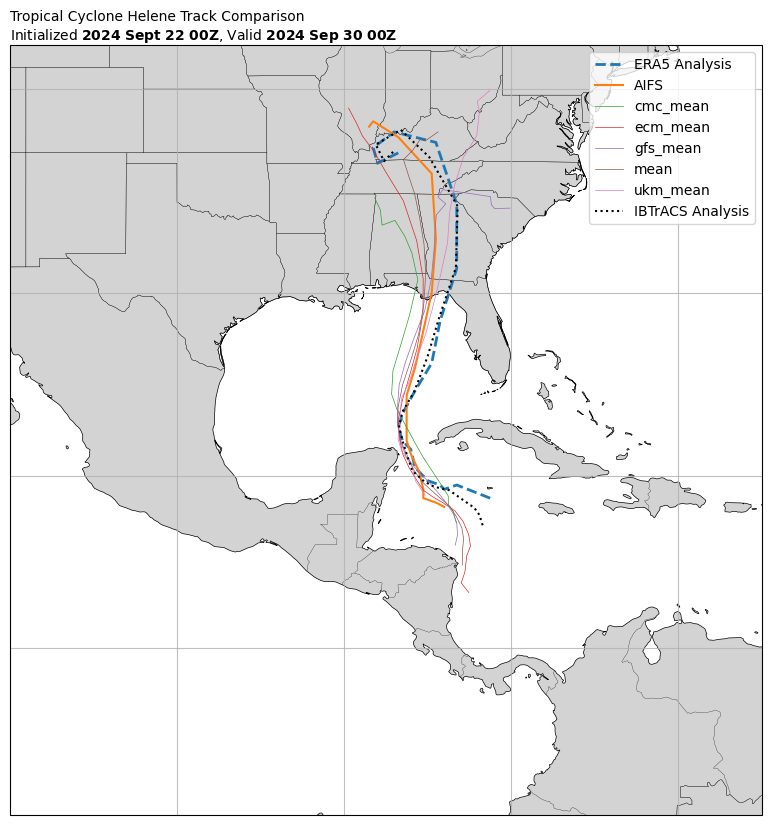

In [449]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Add map features
ax.add_feature(cfeature.BORDERS,linewidth=0.2)
ax.gridlines(alpha=0.8)
ax.add_feature(cfeature.STATES,linewidth=0.2)

ax.add_feature(cfeature.LAND,facecolor='lightgray',edgecolor='k',linewidth=0.5)
ax.set_extent([250,295, 0, 42], crs=ccrs.PlateCarree())

# Create scatter plots colored by vmax using Saffir-Simpson scale
# Define boundaries for Saffir-Simpson categories in m/s
boundaries = [0, 17, 33, 43, 49, 58, 70, 100]  # TD, TS, Cat1-5
colors = ['#ffffff', '#00faf4', '#ffffcc', '#ffe775', '#ffc140', '#ff8f20', '#ff6060', '#b33030']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot ERA5 track
# era5_vmax = [tc.vmax for tc in tctracks[1].track]
# ax.scatter(tctracks[1].lons, tctracks[1].lats, c=era5_vmax, 
#           cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), 
#            marker='o')
p = ax.plot(tctracks[1].lons, tctracks[1].lats, 
        transform=ccrs.PlateCarree(), alpha=1, label='ERA5 Analysis', linestyle='--', linewidth=2)
# ax.scatter(tctracks[1].lons, tctracks[1].lats, c=p[0].get_color(), transform=ccrs.PlateCarree(), 
#            marker='o',s=80)

# Plot AIFS track
aifs_vmax = [tc.vmax for tc in aifs_tctracks[1].track]
# ax.scatter(aifs_tctracks[1].lons, aifs_tctracks[1].lats, c=aifs_vmax,
#           cmap=cmap, norm=norm, transform=ccrs.PlateCarree(),
#           marker='o')
p = ax.plot(aifs_tctracks[1].lons, aifs_tctracks[1].lats,
        transform=ccrs.PlateCarree(), alpha=1, label='AIFS')
# ax.scatter(aifs_tctracks[1].lons, aifs_tctracks[1].lats, c=p[0].get_color(), transform=ccrs.PlateCarree(), 
#            marker='o',s=80)

# Plot TBURG tracks
for name, group in tburg_tracks.groupby('model'):
    if 'mean' in name:
        # ax.scatter(group.lon, group.lat, c=group.vmax,
        #           cmap=cmap, norm=norm, transform=ccrs.PlateCarree(),
        #           marker='o')
        p = ax.plot(group.lon, group.lat,
                transform=ccrs.PlateCarree(), alpha=1, label=name, linewidth=0.5)
    
        # ax.scatter(group.lon, group.lat, c=p[0].get_color(), transform=ccrs.PlateCarree(), 
        #         marker='o',s=80)

# Plot IBTrACS track
# ax.scatter(storm_ds.lon, storm_ds.lat, c=storm_ds.vmax*0.51444, #convert to m/s
#           cmap=cmap, norm=norm, transform=ccrs.PlateCarree(),
#           marker='o')
p = ax.plot(storm_ds.lon, storm_ds.lat, color='k', linestyle=':',
        transform=ccrs.PlateCarree(), alpha=1, label='IBTrACS Analysis')
# ax.scatter(storm_ds.lon, storm_ds.lat, c=p[0].get_color(), transform=ccrs.PlateCarree(), 
#            marker='o',s=80)


# Add colorbar
# plt.colorbar(sm, ax=ax, label='Maximum Wind Speed (m/s)')

ax.legend()
ax.set_title(('Tropical Cyclone Helene Track Comparison\n'
             r'Initialized $\bf{2024\ Sept\ 22\ 00Z}$, Valid $\bf{2024\ Sep\ 30\ 00Z}$'),
             wrap=True,
             loc='left',
             fontsize=10)
plt.show()

# Test on Graphcast GFS Realtime

In [410]:
!uv pip install virtualizarr
from virtualizarr import open_virtual_dataset
import time
time_start = time.time()
virtual_dataset = open_virtual_dataset('s3://noaa-oar-mlwp-data/GRAP_v100_GFS/2025/0617/GRAP_v100_GFS_2025061712_f000_f240_06.nc',
                                       decode_times=True,
                                       loadable_variables=['time','latitude','longitude','level'],
                                       reader_options={'storage_options': {'anon': True}})
virtual_dataset.virtualize.to_kerchunk('graphcast_gfs.parq',format='parquet')
time_end = time.time()
print(f"Time taken: {time_end - time_start} seconds")


48126.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Using Python 3.12.8 environment at: /home/taylor/code/ExtremeWeatherBench/.venv
Audited 1 package in 5ms
Time taken: 72.27548956871033 seconds


In [458]:
ibtracs_tctrack

TCTrack(id=0, track=[TC(id=0, valid_time=Timestamp('2024-09-23 12:00:00'), coordinate=Location(latitude=array(17.2), longitude=array(-81.7)), vmax=array(30), slp=array(1004)), TC(id=0, valid_time=Timestamp('2024-09-23 18:00:00'), coordinate=Location(latitude=array(17.8), longitude=array(-81.9)), vmax=array(35), slp=array(1004)), TC(id=0, valid_time=Timestamp('2024-09-24 00:00:00'), coordinate=Location(latitude=array(18.2), longitude=array(-82.2)), vmax=array(35), slp=array(1002)), TC(id=0, valid_time=Timestamp('2024-09-24 06:00:00'), coordinate=Location(latitude=array(18.6), longitude=array(-82.8)), vmax=array(35), slp=array(1001)), TC(id=0, valid_time=Timestamp('2024-09-24 12:00:00'), coordinate=Location(latitude=array(19.2), longitude=array(-83.7)), vmax=array(40), slp=array(999)), TC(id=0, valid_time=Timestamp('2024-09-24 18:00:00'), coordinate=Location(latitude=array(19.4), longitude=array(-84.6)), vmax=array(45), slp=array(997)), TC(id=0, valid_time=Timestamp('2024-09-25 00:00:00'

In [411]:
storage_options = {
    "remote_protocol": 's3',
    "remote_options": {"anon": True},
}  # options passed to fsspec
open_dataset_options: dict = {"chunks": {}}  # opens passed to xarray

grap_ds = xr.open_dataset(
    'graphcast_gfs.parq',
    engine="kerchunk",
    storage_options=storage_options,
    open_dataset_options=open_dataset_options,
)
grap_ds = grap_ds.compute()
grap_ds = grap_ds.rename({'msl': 'mean_sea_level_pressure', 
                              't': 'temperature', 
                              't2': '2m_temperature',
                              'u': 'u_component_of_wind', 
                              'v': 'v_component_of_wind', 
                              'z': 'geopotential',
                              'u10': '10m_u_component_of_wind',
                              'v10': '10m_v_component_of_wind',
                              })

In [451]:
cyclone_dataset_builder = CycloneDatasetBuilder()
start_date = pd.Timestamp('2025-06-17 12:00:00')
end_date = pd.Timestamp('2025-06-17 12:00:00') + pd.Timedelta(hours=240)
grap_basin = CoordinateBounds(min_lat=5, max_lat=40, min_lon=230, max_lon=320)
grap_cyclone_dataset = cyclone_dataset_builder.build_dataset(grap_ds, start_date, end_date, grap_basin, tc_variable_amount='min').compute()
grap_tctracks = create_tctracks_from_dataset(grap_cyclone_dataset)

In [453]:
grap_tctracks

[TCTrack(id=0, track=[TC(id=0, valid_time=Timestamp('2025-06-17 12:00:00'), coordinate=Location(latitude=array(11.5, dtype=float32), longitude=array(265.75, dtype=float32)), vmax=np.float64(15.797822952270508), slp=array(100388.375, dtype=float32)), TC(id=1, valid_time=Timestamp('2025-06-17 18:00:00'), coordinate=Location(latitude=array(12.25, dtype=float32), longitude=array(266., dtype=float32)), vmax=np.float64(15.846007347106934), slp=array(100317.64, dtype=float32)), TC(id=2, valid_time=Timestamp('2025-06-18 00:00:00'), coordinate=Location(latitude=array(12.5, dtype=float32), longitude=array(265.5, dtype=float32)), vmax=np.float64(15.846007347106934), slp=array(100283.07, dtype=float32)), TC(id=3, valid_time=Timestamp('2025-06-18 06:00:00'), coordinate=Location(latitude=array(13., dtype=float32), longitude=array(265.25, dtype=float32)), vmax=np.float64(16.21864891052246), slp=array(100290.195, dtype=float32)), TC(id=4, valid_time=Timestamp('2025-06-18 12:00:00'), coordinate=Locatio

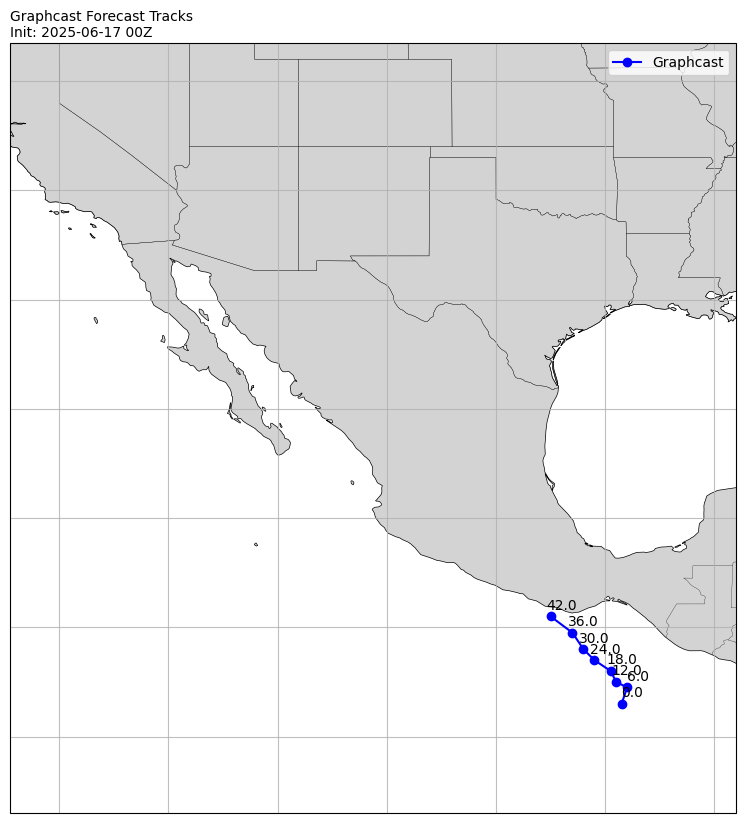

In [456]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# Add map features
ax.add_feature(cfeature.BORDERS,linewidth=0.2)
ax.gridlines(alpha=0.8)
ax.add_feature(cfeature.STATES,linewidth=0.2)

ax.add_feature(cfeature.LAND,facecolor='lightgray',edgecolor='k',linewidth=0.5)

lons = [n.coordinate.longitude for grap_tctrack in grap_tctracks for n in grap_tctrack.track]
lats = [n.coordinate.latitude for grap_tctrack in grap_tctracks for n in grap_tctrack.track]
ax.set_extent([np.min(lons)-5,np.max(lons)+5, np.min(lats)-5, np.max(lats)+5], crs=ccrs.PlateCarree())

# Plot first point of ERA5 track with larger marker and annotation
[n.plot(ax=ax,transform=ccrs.PlateCarree(),label='Graphcast',color='b',marker='o') for n in grap_tctracks[0:1]]
[ax.annotate((n.valid_time - pd.Timestamp('2025-06-17 12:00:00')).total_seconds()/3600, xy=(n.coordinate.longitude+2, n.coordinate.latitude+2), xytext=(n.coordinate.longitude+0.5, n.coordinate.latitude+0.5), fontsize=10, ha='center', va='center') for n in grap_tctracks[0].track]
ax.legend()
ax.set_title('Graphcast Forecast Tracks\nInit: 2025-06-17 00Z', wrap=True, loc='left', fontsize=10)
plt.show()



# Positive TC Formation Detection
This metric will look back on model outputs up to 240 hours before TC formation and determines if a TC signature is identified within 8 (can be changed) great circle degrees of first IBTrACS position, outputting the resulting lead time which the model produces a spatially colocated TC

In [314]:
start_date = pd.Timestamp('2024-09-20 00:00')
end_date = pd.Timestamp('2024-09-29 00:00')
aifs_early_ds = xr.open_dataset('/home/taylor/data/aifs.era5.20240917T18Z.nc',chunks='auto')
cyclone_dataset_builder = CycloneDatasetBuilder()
aifs_early_cyclone_dataset = cyclone_dataset_builder.build_dataset(aifs_early_ds, start_date, end_date, basin, tc_variable_amount='min')
aifs_early_cyclone_dataset = aifs_early_cyclone_dataset.compute()
aifs_early_tctracks = create_tctracks_from_dataset(aifs_early_cyclone_dataset)

In [ ]:
era5_helene_tctrack = tctracks[1]
aifs_helene_tctrack = aifs_tctracks[1]
aifs_early_helene_tctrack = aifs_early_tctracks[1]

In [474]:
def tc_formation_detection(predicted_tc_tracks: list[TCTrack], valid_track: TCTrack):
    """
    Detects the formation of a tropical cyclone from a list of TCTracks and a cyclone dataset.
    """
    time_differences = []
    formation_distances = []
    for tc_track in predicted_tc_tracks:
        time_difference = tc_track.valid_times[0] - valid_track.valid_times[0]
        formation_distance = calculate_haversine_degree_distance((tc_track.lats[0], tc_track.lons[0]), (valid_track.lats[0], valid_track.lons[0]))
        if (
            time_difference < pd.Timedelta(hours=48) and
            formation_distance < 5
            ):
                time_differences.append(time_difference)
                formation_distances.append(np.radians(formation_distance) * 6371)
    return np.min(time_differences), np.round(np.min(formation_distances), 2)

# in km and timedelta
print('AIFS Init 2024 Sept 17 18Z:', tc_formation_detection(aifs_early_tctracks, ibtracs_tctrack))
print('AIFS Init 2024 Sept 22 00Z:', tc_formation_detection(aifs_tctracks, ibtracs_tctrack))
print('ECM Init 2024 Sept 22 00Z:', tc_formation_detection([ecm_tctrack], ibtracs_tctrack))

AIFS Init 2024 Sept 17 18Z: (Timedelta('1 days 00:00:00'), np.float64(508.11))
AIFS Init 2024 Sept 22 00Z: (Timedelta('0 days 18:00:00'), np.float64(270.14))
ECM Init 2024 Sept 22 00Z: (Timedelta('-1 days +00:00:00'), np.float64(443.79))


# Spatial Landfall Error
Determines the location error of landfall as a function of lead time

In [396]:
def find_landfall(tctrack: TCTrack):
    """
    Finds the first point where a tropical cyclone track intersects with land by linearly interpolating between track points.
    
    Args:
        tctrack: TCTrack object containing the cyclone track
        
    Returns:
        Tuple of (time, lat, lon) at landfall point, or None if no landfall found
    """
    from shapely.geometry import LineString
    from cartopy.io.shapereader import natural_earth, Reader
    
    # Get coastlines from Natural Earth
    land = natural_earth(category='physical', name='land', resolution='10m')
    land_geom = list(Reader(land).geometries())[0]

    # Convert to -180 to 180 degree longitude (for now)
    lons = (np.array(tctrack.lons) + 180) % 360 - 180
    # Check each track segment
    for i in range(len(tctrack.track)-1):
        # Create line segment between consecutive points
        segment = LineString([(lons[i], tctrack.lats[i]), 
                            (lons[i+1], tctrack.lats[i+1])])
        # Check if segment intersects land
        if segment.intersects(land_geom):
            intersection = segment.intersection(land_geom)
            landfall_lon, landfall_lat = intersection.coords[0]
            
            # Linearly interpolate time based on distance along segment
            full_dist = segment.length
            landfall_dist = LineString([(lons[i], tctrack.lats[i]), 
                                      (landfall_lon, landfall_lat)]).length
            frac = landfall_dist / full_dist
            
            landfall_time = tctrack.valid_times[i] + frac * (tctrack.valid_times[i+1] - tctrack.valid_times[i])
            return TC(
                id=0,
                valid_time=landfall_time,
                coordinate=Location(latitude=landfall_lat, longitude=convert_longitude_to_360(landfall_lon)),
                vmax=tctrack.vmax[i],
                slp=tctrack.slp[i]
                )
            
    return None

# Find landfall point for IBTrACS track and then AIFS tracks
landfall_actual_interpolated = find_landfall(ibtracs_tctrack)
landfall_aifs_early_interpolated = [find_landfall(n) for n in aifs_early_tctracks]
landfall_aifs_early_interpolated = [n for n in landfall_aifs_early_interpolated if n is not None][0]
landfall_aifs_interpolated = [find_landfall(n) for n in aifs_tctracks]
landfall_aifs_interpolated = [n for n in landfall_aifs_interpolated if n is not None][0]

In [475]:
landfall_ecm_tctrack = find_landfall(ecm_tctrack)

In [478]:
np.round(np.radians(calculate_haversine_degree_distance((landfall_ecm_tctrack.coordinate.latitude, landfall_ecm_tctrack.coordinate.longitude), (landfall_actual_interpolated.coordinate.latitude, landfall_actual_interpolated.coordinate.longitude))) * 6371, 2)

np.float64(144.68)

In [398]:
# in km
np.round(np.radians(calculate_haversine_degree_distance(landfall_aifs_interpolated.coordinate, landfall_actual_interpolated.coordinate)) * 6371, 2)

np.float64(99.85)

# Temporal Landfall Error
Determines the forward motion error of landfall as a function of lead time

In [479]:
np.round((landfall_ecm_tctrack.valid_time - landfall_actual_interpolated.valid_time).total_seconds() / 3600,2)

np.float64(5.64)

In [399]:
# in hours
np.round((landfall_aifs_interpolated.valid_time - landfall_actual_interpolated.valid_time).total_seconds() / 3600,2)

np.float64(-3.67)

# MAE Landfall Intensity
Due to resolution error it is expected to have a weak bias in the SLP field. What is the MAE at landfall for the predicted TC?

In [481]:
np.round(abs(landfall_ecm_tctrack.slp - landfall_actual_interpolated.slp), 2)

np.int64(47)

In [405]:
# in hPa
np.round(abs(landfall_aifs_interpolated.slp/100 - landfall_actual_interpolated.slp), 2)

np.float64(40.34)